In [1]:

import cv2  # Not actually necessary if you just want to create an image.
import numpy as np
from PIL import ImageFont, ImageDraw, Image  
import h5py
  

In [2]:
  
def generate(text, filepath, fontpath):
    height = 100
    width = 1
    blank_image = np.zeros((height,width,3), np.uint8)
    blank_image[:,:] = (255,255,255)  
    image = blank_image  
    # Convert the image to RGB (OpenCV uses BGR)  
    cv2_im_rgb = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)  

    # Pass the image to PIL  
    pil_im = Image.fromarray(cv2_im_rgb)  

    draw = ImageDraw.Draw(pil_im)  
    # use a truetype font  
    font = ImageFont.truetype(fontpath, 100)  


    # Draw the text  
    draw.text((4,0), text, font=font, fill=(0,0,0))

    # Get back the image to OpenCV  
    cv2_im_processed = cv2.cvtColor(np.array(pil_im), cv2.COLOR_RGB2BGR)  
#     cv2.imshow(cv2_im_processed) 
    cv2.imwrite(filepath, cv2_im_processed)


In [3]:
font_list = ['alphabetizedCassetteTapes.ttf','ASensibleArmadillo.ttf','ArdiniaDemo.ttf','Buttercake.ttf']

In [4]:
path_to_font = "/home/kuadmin01/terng/Fonts/"

In [11]:
text = 'aa'
for i in range(len(font_list)):
    text += 'a'
    generate(text, './test' + str(i)+ '.png',path_to_font+font_list[i] )


In [6]:

def truncateLabel(text, maxTextLen):
        # ctc_loss can't compute loss if it cannot find a mapping between text label and input
        # labels. Repeat letters cost double because of the blank symbol needing to be inserted.
        # If a too-long label is provided, ctc_loss returns an infinite gradient
        cost = 0
        for i in range(len(text)):
            if i != 0 and text[i] == text[i-1]:
                cost += 2
            else:
                cost += 1
            if cost > maxTextLen:
                return text[:i]
        return text
   

In [7]:

def getGeneratedData(font=None, Fake=True):
    f = open('/home/kuadmin01/terng/SeniorProjectMaterial/words_raw.txt')
    datapath = []
    label = []
    fake_datapath = []
    fake_datalabel = []

    for line in f:
        # ignore comment line
        if not line or line[0] == '#':
            continue

        lineSplit = line.strip().split(' ')
        fileNameSplit = lineSplit[0].split('-')
        fileName =  '/home/kuadmin01/terng/HTR_dataset_word/' + \
        fileNameSplit[0] + '/' + fileNameSplit[0] + '-' + \
        fileNameSplit[1] + '/' + lineSplit[0] + '.png'

        gtText = truncateLabel(' '.join(lineSplit[8:]), 128)
        
        # if len(gtText)>2:
        if len(fileName)>0 and len(gtText)>0:
            datapath.append(fileName)
            label.append(gtText)
            
            if Fake:
                generated_path = '/home/kuadmin01/terng/HTR_generated_dataset/' +font.split('.')[0]+'_'+ lineSplit[0] + '.png'
                fake_datapath.append(generated_path)
                fake_datalabel.append(gtText)
            
    if Fake:
        return fake_datapath, fake_datalabel
    else:
        return datapath, label



In [8]:
# !wget --user=terng03412 --password=1q2w3e4rterng http://www.fki.inf.unibe.ch/DBs/iamDB/data/words/words.tgz

In [9]:
import html
import re
import string

"""
DeepSpell based text cleaning process.
    Tal Weiss.
    Deep Spelling.
    Medium: https://machinelearnings.co/deep-spelling-9ffef96a24f6#.2c9pu8nlm
    Github: https://github.com/MajorTal/DeepSpell
"""

RE_DASH_FILTER = re.compile(r'[\-\˗\֊\‐\‑\‒\–\—\⁻\₋\−\﹣\－]', re.UNICODE)
RE_APOSTROPHE_FILTER = re.compile(r'&#39;|[ʼ՚＇‘’‛❛❜ߴߵ`‵´ˊˋ{}{}{}{}{}{}{}{}{}]'.format(
    chr(768), chr(769), chr(832), chr(833), chr(2387),
    chr(5151), chr(5152), chr(65344), chr(8242)), re.UNICODE)
RE_RESERVED_CHAR_FILTER = re.compile(r'[¶¤«»]', re.UNICODE)
RE_LEFT_PARENTH_FILTER = re.compile(r'[\(\[\{\⁽\₍\❨\❪\﹙\（]', re.UNICODE)
RE_RIGHT_PARENTH_FILTER = re.compile(r'[\)\]\}\⁾\₎\❩\❫\﹚\）]', re.UNICODE)
RE_BASIC_CLEANER = re.compile(r'[^\w\s{}]'.format(re.escape(string.punctuation)), re.UNICODE)

LEFT_PUNCTUATION_FILTER = """!%&),.:;<=>?@\\]^_`|}~"""
RIGHT_PUNCTUATION_FILTER = """"(/<=>@[\\^_`{|~"""
NORMALIZE_WHITESPACE_REGEX = re.compile(r'[^\S\n]+', re.UNICODE)

In [10]:

def text_standardize(text):
    """Organize/add spaces around punctuation marks"""

    if text is None:
        return ""

    text = html.unescape(text).replace("\\n", "").replace("\\t", "")

    text = RE_RESERVED_CHAR_FILTER.sub("", text)
    text = RE_DASH_FILTER.sub("-", text)
    text = RE_APOSTROPHE_FILTER.sub("'", text)
    text = RE_LEFT_PARENTH_FILTER.sub("(", text)
    text = RE_RIGHT_PARENTH_FILTER.sub(")", text)
    text = RE_BASIC_CLEANER.sub("", text)

    text = text.lstrip(LEFT_PUNCTUATION_FILTER)
    text = text.rstrip(RIGHT_PUNCTUATION_FILTER)
    text = text.translate(str.maketrans({c: f" {c} " for c in string.punctuation}))
    text = NORMALIZE_WHITESPACE_REGEX.sub(" ", text.strip())

    return text


In [11]:
"""
Sauvola binarization based in,
    J. Sauvola, T. Seppanen, S. Haapakoski, M. Pietikainen,
    Adaptive Document Binarization, in IEEE Computer Society Washington, 1997.
"""

def sauvola(img, window, thresh, k):
    """Sauvola binarization"""

    rows, cols = img.shape
    pad = int(np.floor(window[0] / 2))
    sum2, sqsum = cv2.integral2(
        cv2.copyMakeBorder(img, pad, pad, pad, pad, cv2.BORDER_CONSTANT))

    isum = sum2[window[0]:rows + window[0], window[1]:cols + window[1]] + \
        sum2[0:rows, 0:cols] - \
        sum2[window[0]:rows + window[0], 0:cols] - \
        sum2[0:rows, window[1]:cols + window[1]]

    isqsum = sqsum[window[0]:rows + window[0], window[1]:cols + window[1]] + \
        sqsum[0:rows, 0:cols] - \
        sqsum[window[0]:rows + window[0], 0:cols] - \
        sqsum[0:rows, window[1]:cols + window[1]]

    ksize = window[0] * window[1]
    mean = isum / ksize
    std = (((isqsum / ksize) - (mean**2) / ksize) / ksize) ** 0.5
    threshold = (mean * (1 + k * (std / thresh - 1))) * (mean >= 100)

    return np.asarray(255 * (img >= threshold), 'uint8')


In [12]:

def remove_cursive_style(img):
    """Remove cursive writing style from image with deslanting algorithm"""

    def calc_y_alpha(vec):
        indices = np.where(vec > 0)[0]
        h_alpha = len(indices)

        if h_alpha > 0:
            delta_y_alpha = indices[h_alpha - 1] - indices[0] + 1

            if h_alpha == delta_y_alpha:
                return h_alpha * h_alpha
        return 0

    alpha_vals = [-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0]
    rows, cols = img.shape
    results = []

    ret, otsu = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    binary = otsu if ret < 127 else sauvola(img, (int(img.shape[0] / 2), int(img.shape[0] / 2)), 127, 1e-2)

    for alpha in alpha_vals:
        shift_x = max(-alpha * rows, 0.)
        size = (cols + int(np.ceil(abs(alpha * rows))), rows)
        transform = np.asarray([[1, alpha, shift_x], [0, 1, 0]], dtype=np.float)

        shear_img = cv2.warpAffine(binary, transform, size, cv2.INTER_NEAREST)
        sum_alpha = 0
        sum_alpha += np.apply_along_axis(calc_y_alpha, 0, shear_img)
        results.append([np.sum(sum_alpha), size, transform])

    result = sorted(results, key=lambda x: x[0], reverse=True)[0]
    warp = cv2.warpAffine(img, result[2], result[1], borderValue=255)

    return cv2.resize(warp, dsize=(cols, rows))


In [13]:
def preproc(img, input_size):
    """Make the process with the `input_size` to the scale resize"""
    img_src = img
    if isinstance(img, str):
        img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)

    if isinstance(img, tuple):
        image, boundbox = img
        img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)

        for i in range(len(boundbox)):
            if isinstance(boundbox[i], float):
                total = len(img) if i < 2 else len(img[0])
                boundbox[i] = int(total * boundbox[i])

        img = np.asarray(img[boundbox[0]:boundbox[1], boundbox[2]:boundbox[3]], dtype=np.uint8)

    wt, ht, _ = input_size
    try:
        h, w = np.asarray(img).shape
    except Exception as e:
        print(f"ERROR: {img_src}")
        return

    f = max((w / wt), (h / ht))

    new_size = (max(min(wt, int(w / f)), 1), max(min(ht, int(h / f)), 1))
    img = cv2.resize(img, new_size)

    _, binary = cv2.threshold(img, 254, 255, cv2.THRESH_BINARY)

    if np.sum(img) * 0.8 > np.sum(binary):
        img = illumination_compensation(img)

    img = remove_cursive_style(img)

    target = np.ones([ht, wt], dtype=np.uint8) * 255
    target[0:new_size[1], 0:new_size[0]] = img
    img = cv2.transpose(target)

    return img


In [14]:

def normalization(imgs):
    """Normalize list of images"""

    imgs = np.asarray(imgs).astype(np.float32)
    _, h, w = imgs.shape

    for i in range(len(imgs)):
        m, s = cv2.meanStdDev(imgs[i])
        imgs[i] = imgs[i] - m[0][0]
        imgs[i] = imgs[i] / s[0][0] if s[0][0] > 0 else imgs[i]

    return np.expand_dims(imgs, axis=-1)


In [15]:

def augmentation(imgs,
                 rotation_range=0,
                 scale_range=0,
                 height_shift_range=0,
                 width_shift_range=0,
                 dilate_range=1,
                 erode_range=1):
    """Apply variations to a list of images (rotate, width and height shift, scale, erode, dilate)"""

    imgs = imgs.astype(np.float32)
    _, h, w = imgs.shape

    dilate_kernel = np.ones((int(np.random.uniform(1, dilate_range)),), np.uint8)
    erode_kernel = np.ones((int(np.random.uniform(1, erode_range)),), np.uint8)
    height_shift = np.random.uniform(-height_shift_range, height_shift_range)
    rotation = np.random.uniform(-rotation_range, rotation_range)
    scale = np.random.uniform(1 - scale_range, 1)
    width_shift = np.random.uniform(-width_shift_range, width_shift_range)

    trans_map = np.float32([[1, 0, width_shift * w], [0, 1, height_shift * h]])
    rot_map = cv2.getRotationMatrix2D((w // 2, h // 2), rotation, scale)

    trans_map_aff = np.r_[trans_map, [[0, 0, 1]]]
    rot_map_aff = np.r_[rot_map, [[0, 0, 1]]]
    affine_mat = rot_map_aff.dot(trans_map_aff)[:2, :]

    for i in range(len(imgs)):
        imgs[i] = cv2.warpAffine(imgs[i], affine_mat, (w, h), flags=cv2.INTER_NEAREST, borderValue=255)
        imgs[i] = cv2.erode(imgs[i], erode_kernel, iterations=1)
        imgs[i] = cv2.dilate(imgs[i], dilate_kernel, iterations=1)

    return imgs


In [16]:

def illumination_compensation(img):
    """Illumination compensation technique for text image"""

    def scale(img):
        s = np.max(img) - np.min(img)
        res = img / s
        res -= np.min(res)
        res *= 255
        return res

    img = img.astype(np.float32)
    height, width = img.shape
    sqrt_hw = np.sqrt(height * width)

    bins = np.arange(0, 300, 10)
    bins[26] = 255
    hp = np.histogram(img, bins)
    for i in range(len(hp[0])):
        if hp[0][i] > sqrt_hw:
            hr = i * 10
            break

    np.seterr(divide='ignore', invalid='ignore')
    cei = (img - (hr + 50 * 0.3)) * 2
    cei[cei > 255] = 255
    cei[cei < 0] = 0

    m1 = np.array([-1, 0, 1, -2, 0, 2, -1, 0, 1]).reshape((3, 3))
    m2 = np.array([-2, -1, 0, -1, 0, 1, 0, 1, 2]).reshape((3, 3))
    m3 = np.array([-1, -2, -1, 0, 0, 0, 1, 2, 1]).reshape((3, 3))
    m4 = np.array([0, 1, 2, -1, 0, 1, -2, -1, 0]).reshape((3, 3))

    eg1 = np.abs(cv2.filter2D(img, -1, m1))
    eg2 = np.abs(cv2.filter2D(img, -1, m2))
    eg3 = np.abs(cv2.filter2D(img, -1, m3))
    eg4 = np.abs(cv2.filter2D(img, -1, m4))

    eg_avg = scale((eg1 + eg2 + eg3 + eg4) / 4)

    h, w = eg_avg.shape
    eg_bin = np.zeros((h, w))
    eg_bin[eg_avg >= 30] = 255

    h, w = cei.shape
    cei_bin = np.zeros((h, w))
    cei_bin[cei >= 60] = 255

    h, w = eg_bin.shape
    tli = 255 * np.ones((h, w))
    tli[eg_bin == 255] = 0
    tli[cei_bin == 255] = 0

    kernel = np.ones((3, 3), np.uint8)
    erosion = cv2.erode(tli, kernel, iterations=1)
    int_img = np.array(cei)

    estimate_light_distribution(width, height, erosion, cei, int_img)

    mean_filter = 1 / 121 * np.ones((11, 11), np.uint8)
    ldi = cv2.filter2D(scale(int_img), -1, mean_filter)

    result = np.divide(cei, ldi) * 260
    result[erosion != 0] *= 1.5
    result[result < 0] = 0
    result[result > 255] = 255

    return np.array(result, dtype=np.uint8)


In [17]:

def estimate_light_distribution(width, height, erosion, cei, int_img):
    """Light distribution performed by numba (thanks @Sundrops)"""

    for y in range(width):
        for x in range(height):
            if erosion[x][y] == 0:
                i = x

                while i < erosion.shape[0] and erosion[i][y] == 0:
                    i += 1

                end = i - 1
                n = end - x + 1

                if n <= 30:
                    h, e = [], []

                    for k in range(5):
                        if x - k >= 0:
                            h.append(cei[x - k][y])

                        if end + k < cei.shape[0]:
                            e.append(cei[end + k][y])

                    mpv_h, mpv_e = max(h), max(e)

                    for m in range(n):
                        int_img[x + m][y] = mpv_h + (m + 1) * ((mpv_e - mpv_h) / n)

                x = end
                break
            


In [18]:
datapath = []
label = []
fake_datapath = []
fake_datalabel = []
font_list = ['alphabetizedCassetteTapes.ttf','ASensibleArmadillo.ttf']


In [19]:
for f in font_list:
    genPath, genLabel = getGeneratedData(f)
    fake_datapath += genPath
    fake_datalabel += genLabel
    
datapath, label = getGeneratedData(Fake=False)

input_size = (1024, 128, 1)

FileNotFoundError: [Errno 2] No such file or directory: '/home/kuadmin01/terng/SeniorProjectMaterial/words_raw.txt'

In [216]:
datapath[0]

'/home/kuadmin01/terng/HTR_dataset_word/a01/a01-000u/a01-000u-00-00.png'

In [217]:

fake_datalabel = fake_datalabel[:200]
fake_datapath = fake_datapath[:200]
datapath = datapath[:100]
label = label[:100]

path_to_font = '/home/kuadmin01/terng/Fonts/'

In [218]:

print('-------Generating dataset-------')

for i in range(len(fake_datalabel)):
    font_name = fake_datapath[i].split('/')[-1].split('_')[0] + '.ttf'
    if(i%10000==0):
        print(i)
    generate(fake_datalabel[i],fake_datapath[i],  path_to_font+font_name)
    
# datapath += fake_datapath
# label += fake_datalabel
print('data length --> ' + str(len(datapath)))

-------Generating dataset-------
0
data length --> 100


In [219]:

import random
number_list = np.arange(0, len(datapath))
print ("Original list : ",  number_list)

random.shuffle(number_list) #shuffle method
print ("List after first shuffle  : ",  number_list)
#train, validate, test = 0.7, 0.1, 0.2
shuffled = number_list.tolist()

Original list :  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
List after first shuffle  :  [29 55 95  7 13 92 16 74 21 20 76 68 60 52 27 78 86 24 14 96 42 49 85 40
 94 77 75 93 69 72 37 73 23 66 65 45 28 97 80 33 64 81 11 62  9  6 82  2
 70 54 35 89 48 22 12 34 53 50 63  4 25 98 90 51 87 43 88 32 83 31 56  3
 41 67 91 19 61 18 17 58 59  0 79  5  1 26 84 39 99 44 46 15 10  8 36 38
 30 71 47 57]


In [258]:

train_data_order = shuffled[:int(0.7*len(shuffled))]
test_data_order = shuffled[int(0.7*len(shuffled)):int(0.9*len(shuffled))]
valid_data_order = shuffled[int(0.9*len(shuffled)): int(len(shuffled))]

print('test : ' + str(len(test_data_order)))
print('train : '+ str(len(train_data_order)))
print('valid : ' + str(len(valid_data_order)))

partitions = ['train', 'test', 'valid']
dataset = dict()
data = [train_data_order, test_data_order, valid_data_order]


test : 20
train : 70
valid : 10


In [259]:

for i in range(len(partitions)):
    dataset[partitions[i]] = {"dt": [], "gt": []}
    for j in data[i]:
        dataset[partitions[i]]['dt'].append(datapath[j])
        dataset[partitions[i]]['gt'].append(label[j])

In [260]:


for i in range(len(partitions)): 
    gt = []
    dt = []
    for d, g in zip(dataset[partitions[i]]['dt'],dataset[partitions[i]]['gt']):
        
        txt = text_standardize(g).encode()
        if(len(txt)>0):
            gt.append(txt)
            dt.append(preproc(d, input_size))
            
    
    dataset[partitions[i]]['gt'] = gt
    dataset[partitions[i]]['dt'] = dt
    
#     with h5py.File('/home/kuadmin01/terng/test_daaset.hdf5', "a") as hf:
#         hf.create_dataset(f"{i}/dt", data=dataset[partitions[i]]['dt'], compression="gzip", compression_opts=9)
#         hf.create_dataset(f"{i}/gt", data=dataset[partitions[i]]['gt'], compression="gzip", compression_opts=9)
#         print(f"[OK] {i} partition.")

# print(f"Transformation finished.")



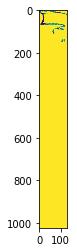

In [235]:

imgplot = plt.imshow(dataset['train']['dt'][2])
plt.show()

In [261]:
for i in partitions:
    with h5py.File('/home/kuadmin01/terng/test_daaset.hdf5', "a") as hf:
        hf.create_dataset(f"{i}/dt", data=dataset[i]['dt'], compression="gzip", compression_opts=9)
        hf.create_dataset(f"{i}/gt", data=dataset[i]['gt'], compression="gzip", compression_opts=9)
        print(f"[OK] {i} partition.")

print(f"Transformation finished.")

[OK] train partition.
[OK] test partition.
[OK] valid partition.
Transformation finished.


In [ ]:
%cd  terng

In [253]:
!rm test_daaset.hdf5